# Home Selling Price Predictive Modeling

##### Derry Li
##### April 2022

## Problem Statement

About 4 years ago, Zillow decided to make a major commitment to “iBuying,” the computer-automated purchasing of homes to flip using a pricing algorithm, with the launch of Zillow Offers (“ZO”). This led to a series of expected financial loss caused by high error rates from ZO, creating turmoils in the housing market and within Zillow. 
__This project aims to build a model with a wide array of features for the purpose of prediction, in order to help businesses assess housing prices more robustly, and avoid scenerios similar to the one endured by Zillow.__
We define that a robust model good for business use is one that is better than the simple model and accounts for over 92% of the variation in Sale Price. 

## Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, Lasso, RidgeCV, Ridge, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

from scipy.stats import skew, norm

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
sns.set_palette(sns.color_palette('muted'))

## Importing the datasets

In [3]:
train = pd.read_csv('../datasets/train.csv', keep_default_na=False, na_values='')
test = pd.read_csv('../datasets/test.csv', keep_default_na=False, na_values='')

In [4]:
train.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

## Data Dictionary

To understand the dataset and feature information better, please see the [data dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).

## Data Cleaning

In [5]:
df = train.drop(columns = ['Id', 'PID'])

#### Clean column names format:

In [6]:
df.columns = df.columns.str.lower().str.replace(' ','_')

#### Convert year columns to more meaningful data:

In [7]:
yr_cols = [col for col in df.columns if 'year' in col or 'yr' in col]

df[yr_cols] = 2010 - df[yr_cols]

#### Check for obvious outliers with simple linear regression:

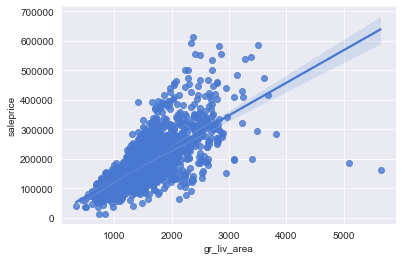

In [8]:
sns.regplot(x='gr_liv_area', y='saleprice', data=df);

Wee see 2 extreme outliers where living area > 5,000 but with low prices. We remove them.

In [9]:
df = df[df['gr_liv_area']<5000]

## Preliminery EDA

#### Now we compute a correlation heatmap to examine which features we can use to build simple model:

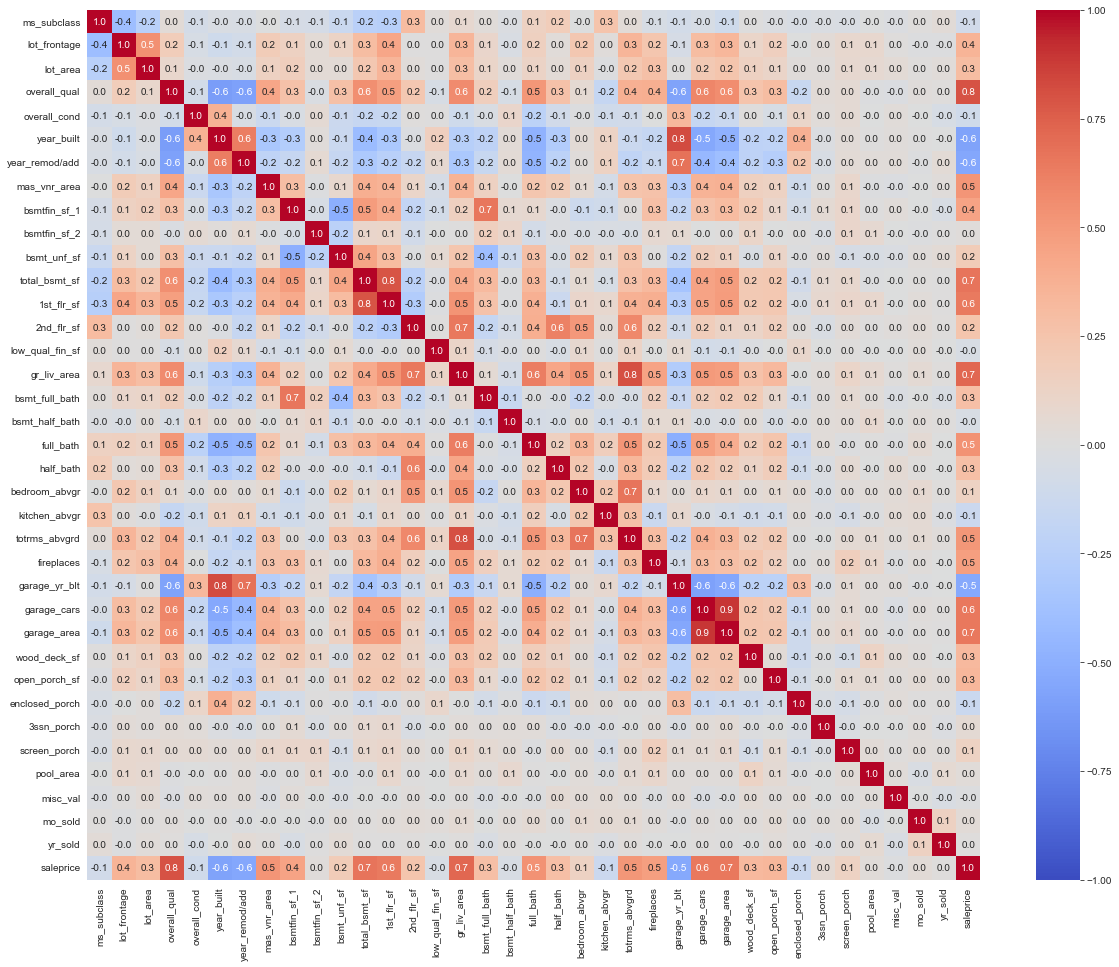

In [10]:
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), vmin=-1, vmax=1,cmap='coolwarm', annot=True, fmt='.1f');

We see that overall_qual is highly correlated with prices, and lot_area is moderatly correlated with both. 

---

## Let's build a base model using overall_qual and lot_area

In [11]:
X = df[['lot_area', 'overall_qual']]
y = df.saleprice

#### Data preprocessing - check for skewness in target feature: 

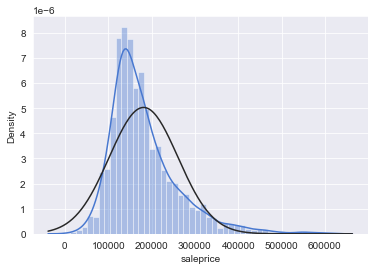

In [12]:
sns.distplot(y, fit=norm);

We see our target is right skewed. Perform log transformation on y:

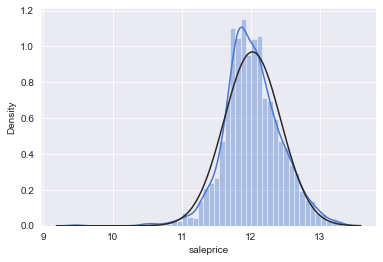

In [13]:
sns.distplot(np.log1p(y), fit=norm);

Now we see the distribution is more normalized.

In [14]:
y = np.log1p(y)

We will do the same for predictor features as well after replacing ordinal features with numeric values.

#### Perform train_test_split:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47)

#### Scale our dataset:

In [16]:
ss = StandardScaler()
X_train_sc = pd.DataFrame(ss.fit_transform(X_train), columns=ss.get_feature_names_out())
X_test_sc =  pd.DataFrame(ss.transform(X_test), columns=ss.get_feature_names_out())

In [17]:
base_model = LinearRegression()
base_model.fit(X_train_sc, y_train)

LinearRegression()

In [18]:
base_model.score(X_train_sc, y_train), base_model.score(X_test_sc, y_test)

(0.7246993276306661, 0.728841092979843)

In [19]:
mean_squared_error(y_train, base_model.predict(X_train_sc), squared=False), mean_squared_error(y_test, base_model.predict(X_test_sc), squared=False)

(0.216900420441487, 0.21110618976825282)

In [20]:
mean_squared_error(np.expm1(y_train), np.expm1(base_model.predict(X_train_sc)), squared=False), mean_squared_error(np.expm1(y_test), np.expm1(base_model.predict(X_test_sc)), squared=False)

(44311.615307031, 40322.745545472935)

In [21]:
cross_val_score(base_model, X_train_sc, y_train).mean(), cross_val_score(base_model, X_test_sc, y_test).mean()

(0.7161346257536564, 0.73407839944282)

#### Our base score is shown above, around 0.72 for R2 and around 40,000 for RMSE, for both train and test set.

---

## Time to build a more robust model !

### We define X and y again: 

In [22]:
X = df.drop(columns='saleprice')
y = np.log1p(df.saleprice) # NOTE: we log transform y to normalize the distribution

### Data Preprocessing - Ordinal Encoding

There are some ordinal columns we consider to potentially one hot encode. We use boxplot to see if OHE on these features are appropriate:

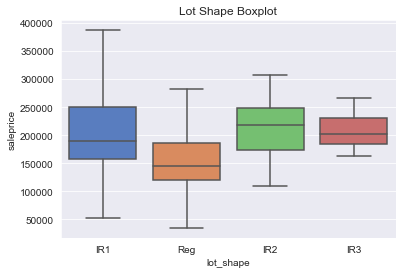

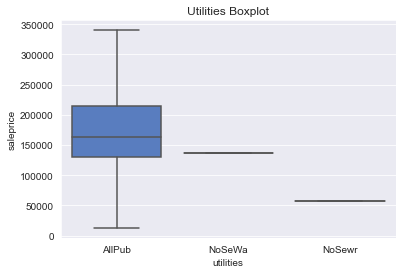

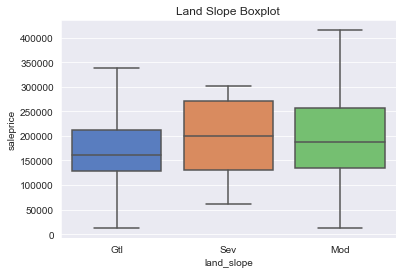

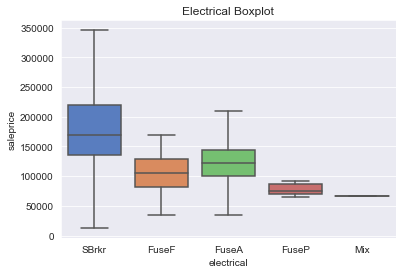

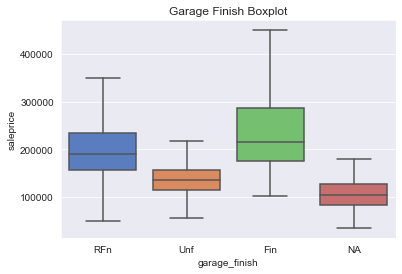

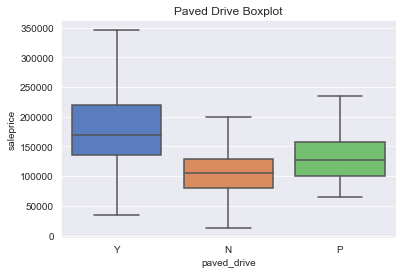

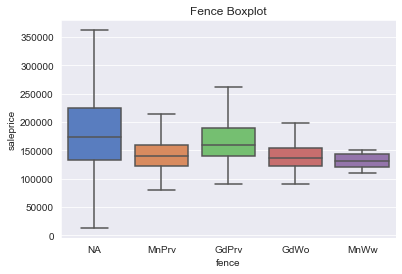

In [23]:
ohe_ord_cols = ['lot_shape', 'utilities', 'land_slope', 'electrical','garage_finish','paved_drive','fence']
for col in ohe_ord_cols:
    sns.boxplot(x=col, y='saleprice', data=df, showfliers=False)
    plt.title(col.title().replace('_', ' ') + ' Boxplot')
    plt.show()

We see from above that lot_shape have relatively constant ranges of saleprice across its shape options and does not follow a pattern, whereas the rest of the ordinal features seem to vary in saleprices depending on feature options. Thus we only include lot_shape to be in OHE, and ordinally encode the rest:

In [24]:
ord_cols = ['utilities','land_slope','exter_qual','exter_cond','bsmt_qual','bsmt_cond','bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2',
            'heating_qc','electrical','kitchen_qual', 'functional','fireplace_qu','garage_finish','garage_qual','garage_cond',
            'paved_drive','pool_qc','fence']

#### Here we use best judgement to determine the numeric values of each ordinal values:

In [25]:
ord_dict = {
    'AllPub': 4,'NoSewr': 3,'NoSeWa': 2, 'ELO': 1,
    'Gtl': 3, 'Mod': 2, 'Sev': 1,
    'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0,
    'Av': 3, 'Mn': 2, 'No': 1,
    'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf':1,
    'SBrkr': 5, 'FuseA': 4, 'FuseF': 3, 'FuseP': 2, 'Mix': 1,
    'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4,'Maj2': 3, 'Sev':2, 'Sal':1,
    'Fin': 3, 'RFn': 2, 'Unf':1,
    'Y':3, 'P':2, 'N':1,
    'GdPrv': 4, 'MnPrv':3, 'GdWo':2, 'MnWw':1,
    'None': 0
}

#### Replace ordinal with numeric values: 

In [26]:
X[ord_cols] = X[ord_cols].replace(ord_dict)

----

### Data Prepressing - Skewness 

#### Now that we have tranformed all necessary non-catagorical columns to numeric columns, we check for skewed numeric features:

In [27]:
numeric_cols = [i for i in X.columns if i not in ord_cols and X[i].dtype!=object and i!='ms_subclass']

#### Columns with skew > 0.6 is moderately-to-severely right skewed. We fix by using Log tranform :

In [28]:
skewed_numeric_cols = [col for col in numeric_cols if skew(X[col])>0.6]

In [29]:
# note: we use log1p() instead of log() in case of 0 values
X[skewed_numeric_cols] = X[skewed_numeric_cols].apply(lambda x: np.log1p(x)) 

---

### Now that we addressed skewness and numerized ordinal values, we are ready to train-test-split

- Note: we performed the aforementioned two data preprocessing precedures prior to train-test-split because both operations (numerization and log transform) do not take into consideration of train/test, thus no data leakage occured

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47)

----

### Data Preprocessing -  OneHotEncoding

From our earlier EDA, we define the catagorical features to be one hot encoded as follows:

In [31]:
ohe_cat_cols = ['ms_subclass', 'ms_zoning', 'lot_shape', 'street', 'alley', 'land_contour', 'lot_config','neighborhood', 'condition_1', 'condition_2', 
            'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type','foundation', 'heating', 'central_air',
            'garage_type', 'misc_feature', 'sale_type', 'mo_sold']

In [32]:
ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
encoder = make_column_transformer(
    (ohe, ohe_cat_cols),
    remainder='passthrough',
    verbose_feature_names_out=False,
)

In [33]:
X_train_enc = encoder.fit_transform(X_train)
X_train_enc = pd.DataFrame(X_train_enc, columns=encoder.get_feature_names_out())

X_test_enc = encoder.transform(X_test)
X_test_enc = pd.DataFrame(X_test_enc, columns=encoder.get_feature_names_out())

In [34]:
X_train_enc.head()

,ms_subclass_30,ms_subclass_40,ms_subclass_45,ms_subclass_50,ms_subclass_60,ms_subclass_70,ms_subclass_75,ms_subclass_80,ms_subclass_85,ms_subclass_90,ms_subclass_120,ms_subclass_160,ms_subclass_180,ms_subclass_190,ms_zoning_C (all),ms_zoning_FV,ms_zoning_RH,ms_zoning_RL,ms_zoning_RM,lot_shape_IR2,lot_shape_IR3,lot_shape_Reg,street_Pave,alley_NA,alley_Pave,land_contour_HLS,land_contour_Low,land_contour_Lvl,lot_config_CulDSac,lot_config_FR2,lot_config_FR3,lot_config_Inside,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_Greens,neighborhood_GrnHill,neighborhood_IDOTRR,neighborhood_Landmrk,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,condition_1_Feedr,condition_1_Norm,condition_1_PosA,condition_1_PosN,condition_1_RRAe,condition_1_RRAn,condition_1_RRNe,condition_1_RRNn,condition_2_Feedr,condition_2_Norm,condition_2_PosA,condition_2_PosN,condition_2_RRAe,condition_2_RRNn,bldg_type_2fmCon,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,house_style_1.5Unf,house_style_1Story,house_style_2.5Fin,house_style_2.5Unf,house_style_2Story,house_style_SFoyer,house_style_SLvl,roof_style_Gable,roof_style_Gambrel,roof_style_Hip,roof_style_Mansard,roof_style_Shed,roof_matl_Membran,roof_matl_Tar&Grv,roof_matl_WdShake,roof_matl_WdShngl,exterior_1st_AsphShn,exterior_1st_BrkComm,exterior_1st_BrkFace,exterior_1st_CBlock,exterior_1st_CemntBd,exterior_1st_HdBoard,exterior_1st_MetalSd,exterior_1st_Plywood,exterior_1st_Stone,exterior_1st_Stucco,exterior_1st_VinylSd,exterior_1st_Wd Sdng,exterior_1st_WdShing,exterior_2nd_AsphShn,exterior_2nd_Brk Cmn,exterior_2nd_BrkFace,exterior_2nd_CBlock,exterior_2nd_CmentBd,exterior_2nd_HdBoard,exterior_2nd_ImStucc,exterior_2nd_MetalSd,exterior_2nd_Plywood,exterior_2nd_Stone,exterior_2nd_Stucco,exterior_2nd_VinylSd,exterior_2nd_Wd Sdng,exterior_2nd_Wd Shng,mas_vnr_type_BrkFace,mas_vnr_type_None,mas_vnr_type_Stone,mas_vnr_type_nan,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,heating_GasW,heating_Grav,heating_OthW,heating_Wall,central_air_Y,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,garage_type_NA,misc_feature_NA,misc_feature_Othr,misc_feature_Shed,misc_feature_TenC,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_WD,mo_sold_2,mo_sold_3,mo_sold_4,mo_sold_5,mo_sold_6,mo_sold_7,mo_sold_8,mo_sold_9,mo_sold_10,mo_sold_11,mo_sold_12,lot_frontage,lot_area,utilities,land_slope,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,exter_cond,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating_qc,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_val,yr_sold
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

#### However, we notice many missing values in the data:

In [35]:
null_count = df.isnull().sum().loc[lambda x: (x!=0)].to_frame(name='null_count')
types = df[df.isnull().sum().loc[lambda x: (x!=0)].index].dtypes.to_frame(name='dtype')
pd.merge(null_count, types, left_index=True, right_index=True)

,null_count,dtype
lot_frontage,330,float64
mas_vnr_type,22,object
mas_vnr_area,22,float64
bsmt_qual,1,object
bsmt_cond,1,object
bsmt_exposure,4,object
bsmtfin_type_1,1,object
bsmtfin_sf_1,1,float64
bsmtfin_type_2,2,object
bsmtfin_sf_2,1,float64


--- 

### Data Preprocessing - KNN Imputer for missing values + LASSO for feature selection

#### We set up a pipeline to evaluate best $k$ for KNN_imputer and best $\alpha$ for LASSO using GridSearch:

In [36]:
pipe1 = Pipeline([
    ('ss', StandardScaler()),
    ('knn_imp', KNNImputer()), 
    ('lasso_reg', Lasso())
])

In [37]:
pipe1_params = {
    'knn_imp__n_neighbors': [i for i in range(1, 10) if i%2],
    'knn_imp__weights': ['uniform', 'distance'],
    'lasso_reg__alpha': np.arange(0.001, 500, 5)
}

In [38]:
gs1 = GridSearchCV(pipe1, param_grid=pipe1_params,n_jobs=-1)

In [39]:
gs1.fit(X_train_enc, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('knn_imp', KNNImputer()),
                                       ('lasso_reg', Lasso())]),
             n_jobs=-1,
             param_grid={'knn_imp__n_neighbors': [1, 3, 5, 7, 9],
                         'knn_imp__weights': ['uniform', 'distance'],
                         'lasso_reg__alpha': array([1.00000e-03, 5.00100e+00, 1.00010e+01, 1.50010e+01, 2.00010e+01,
       2.50010e+01, 3.00010e+01, 3.50010e+01, 4.00010e+01, 4.500...
       3.50001e+02, 3.55001e+02, 3.60001e+02, 3.65001e+02, 3.70001e+02,
       3.75001e+02, 3.80001e+02, 3.85001e+02, 3.90001e+02, 3.95001e+02,
       4.00001e+02, 4.05001e+02, 4.10001e+02, 4.15001e+02, 4.20001e+02,
       4.25001e+02, 4.30001e+02, 4.35001e+02, 4.40001e+02, 4.45001e+02,
       4.50001e+02, 4.55001e+02, 4.60001e+02, 4.65001e+02, 4.70001e+02,
       4.75001e+02, 4.80001e+02, 4.85001e+02, 4.90001e+02, 4.95001e+02])})

In [40]:
gs1.best_estimator_

Pipeline(steps=[('ss', StandardScaler()), ('knn_imp', KNNImputer()),
                ('lasso_reg', Lasso(alpha=0.001))])

In [41]:
gs1.best_score_

0.9142379415348337

#### Deeper dive - We see that $\alpha$ is around 0.001, so we test $\alpha$ more granularly around the range to tune it further:

In [42]:
pipe2 = Pipeline([
    ('ss', StandardScaler()),
    ('knn_imp', KNNImputer()), 
    ('lasso_reg', Lasso())
])

pipe2_params = {
    'knn_imp__n_neighbors': [i for i in range(1, 10) if i%2],
    'knn_imp__weights': ['uniform', 'distance'],
    'lasso_reg__alpha': np.arange(0.0001, 0.1, 0.001)
}

gs2 = GridSearchCV(pipe2, param_grid=pipe2_params,n_jobs=-1)

In [ ]:
gs2.fit(X_train_enc, y_train)

In [44]:
gs2.best_estimator_

Pipeline(steps=[('ss', StandardScaler()), ('knn_imp', KNNImputer()),
                ('lasso_reg', Lasso(alpha=0.0031))])

In [45]:
gs2.best_score_

0.9158578679722377

In [46]:
gs2.score(X_test_enc, y_test)

0.9201596530691678

#### We find that $\alpha = 0.0031$, $k = 5$ yields the best score. We proceed in accordance to this.

----

### Data Preprocessing - Feature Selection

#### We select the features returned by LASSO and redefine training and testing set

In [47]:
# features selected after LASSO
lasso_cols = [col for col, coef in zip(X_train_enc.columns, gs2.best_estimator_.named_steps.lasso_reg.coef_) if coef]

In [48]:
pipe_scale_impute = Pipeline([
    ('ss', StandardScaler()),
    ('knn_impute', KNNImputer(n_neighbors=5)),
])

#### Scale and impute using most optimal hyperparametre returned by our GridSearch

In [49]:
X_train_sc_imp = pipe_scale_impute.fit_transform(X_train_enc)
X_train_sc_imp = pd.DataFrame(X_train_sc_imp, columns=pipe_scale_impute.feature_names_in_)

X_test_sc_imp = pipe_scale_impute.transform(X_test_enc)
X_test_sc_imp = pd.DataFrame(X_test_sc_imp, columns=pipe_scale_impute.feature_names_in_)

In [50]:
X_train_lasso = X_train_sc_imp[lasso_cols]
X_test_lasso = X_test_sc_imp[lasso_cols]

---

### Data Preprocessing - Outlier Removal

#### We check for outliers again with __Standardized Residuals__ on the Lasso model we just fitted on: 

In [51]:
gs2.best_estimator_.named_steps.lasso_reg.fit(X_train_lasso, y_train)

Lasso(alpha=0.0031)

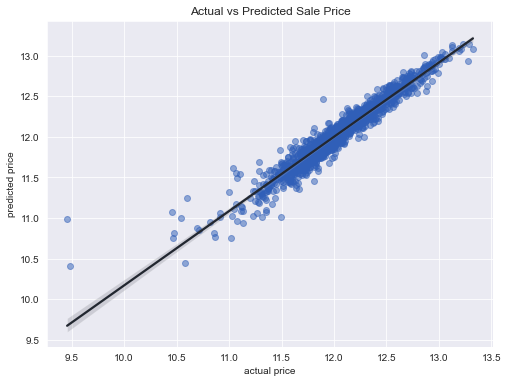

In [52]:
plt.figure(figsize=(8,6))
y_preds = gs2.best_estimator_.named_steps.lasso_reg.predict(X_train_lasso)
sns.regplot(y_train, y_preds, scatter_kws={'color': '#305fb8','alpha': 0.5}, line_kws={'color': '#222730'});
plt.xlabel('actual price')
plt.ylabel('predicted price')
plt.title('Actual vs Predicted Sale Price');

In [53]:
resids = y_train - y_preds
standandized_resids = (resids - resids.mean())/ resids.std()

In [54]:
# define a new df consisting of y, y_pred, and standardized residuals
df_outliers = pd.DataFrame(list(zip(y_train, y_preds, standandized_resids)), columns=['y_train', 'y_pred', 'st_resids'])

# if |standardized residuals| are bigger than 3, then it is considered an outlier
df_outliers['color'] = ['#ab2c31' if abs(r) > 3 else '#305fb8' for r in df_outliers.st_resids]
df_outliers['color'].value_counts()

#305fb8    1519
#ab2c31      17
Name: color, dtype: int64

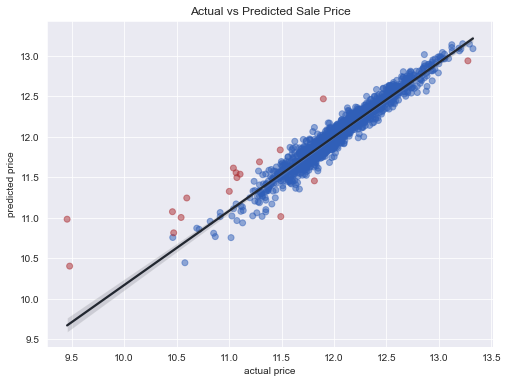

In [55]:
plt.figure(figsize=(8,6))
sns.regplot(y_train, y_preds, scatter_kws={'color': list(df_outliers.color.values), 'alpha': 0.5}, line_kws={'color': '#222730'});
plt.xlabel('actual price')
plt.ylabel('predicted price')
plt.title('Actual vs Predicted Sale Price');

#### We drop the rows with outliers:

In [56]:
y_train = y_train.to_frame().reset_index().drop(columns='index').loc[abs(df_outliers.st_resids)<=3].squeeze()

In [57]:
X_train_lasso = X_train_lasso.loc[abs(df_outliers.st_resids)<=3]

---

### Modeling - LASSO, Ridge, ElasticNet, Linear Regression

In [65]:
def print_result(model):
    print('----------------------------------')
    if type(model) != LinearRegression:
        print('best alpha:', model.alpha_)
        print('----------------------------------')
    print('train score:', model.score(X_train_lasso ,y_train))
    print('test score:', model.score(X_test_lasso ,y_test))
    print('----------------------------------')
    print('train RMSE: ', mean_squared_error(np.expm1(y_train), np.expm1(model.predict(X_train_lasso)), squared=False))
    print('test RMSE: ', mean_squared_error(np.expm1(y_test), np.expm1(model.predict(X_test_lasso)), squared=False))
    print('----------------------------------')
    print('train MAE: ', mean_absolute_error(np.expm1(y_train), np.expm1(model.predict(X_train_lasso))))
    print('test MAE: ', mean_absolute_error(np.expm1(y_test), np.expm1(model.predict(X_test_lasso))))
    print('----------------------------------')
    print('cv train score:',cross_val_score(model, X_train_lasso, y_train, cv = 10).mean())
    print('cv test score:',cross_val_score(model, X_test_lasso, y_test, cv = 10).mean())
    print('----------------------------------')

#### Now we try out different modeling techniques on the selected features:

- #### LASSO

In [66]:
lasso_cv = LassoCV(cv=10).fit(X_train_lasso, y_train)
print_result(lasso_cv)

----------------------------------
best alpha: 0.00045329084851058516
----------------------------------
train score: 0.9568711793790159
test score: 0.9258190122096597
----------------------------------
train RMSE:  15895.552444168052
test RMSE:  21053.366133486605
----------------------------------
train MAE:  11253.750231598722
test MAE:  13588.51038028965
----------------------------------
cv train score: 0.9492751737059686
cv test score: 0.9131099100742673
----------------------------------


- #### Ridge

In [67]:
ridge_cv = RidgeCV(cv=10).fit(X_train_lasso, y_train)
print_result(ridge_cv)

----------------------------------
best alpha: 10.0
----------------------------------
train score: 0.9569771778645679
test score: 0.9250794122759817
----------------------------------
train RMSE:  15883.523840659875
test RMSE:  21163.709116441543
----------------------------------
train MAE:  11260.734254120398
test MAE:  13715.407193647728
----------------------------------
cv train score: 0.9489579156071952
cv test score: 0.9099941594427368
----------------------------------


- #### ElasticNet

In [68]:
elastic_net_cv = ElasticNetCV(cv=10).fit(X_train_lasso, y_train)
print_result(elastic_net_cv)

----------------------------------
best alpha: 0.0009065816970211704
----------------------------------
train score: 0.9568701389530573
test score: 0.9258165704560016
----------------------------------
train RMSE:  15897.580615832454
test RMSE:  21056.674182302067
----------------------------------
train MAE:  11254.812504803802
test MAE:  13590.959063174403
----------------------------------
cv train score: 0.9492818469388912
cv test score: 0.913083369596605
----------------------------------


- #### Linear Regression

In [69]:
lr = LinearRegression()
lr.fit(X_train_lasso, y_train)
print_result(lr)

----------------------------------
train score: 0.9570120798725382
test score: 0.9249446858562053
----------------------------------
train RMSE:  15853.174253210951
test RMSE:  21132.683612642308
----------------------------------
train MAE:  11248.434612464089
test MAE:  13696.362049138732
----------------------------------
cv train score: -9.703127404638085e+17
cv test score: -7.510864045408596e+24
----------------------------------


- We see that LASSO yields the highest R2 mean cross val score out of the 4 models, with average cv train score of 0.949 and test score of 0.913. 
-Lasso also seems to have the closest cv train and test score difference, thus the least overfitted model.
- We also include Root Mean Square Error (RMSE) and Mean Absolute Error (MAE) as additional metrics to evaluate our model off of. Better performing models have smaller RMSE and MAE values.

---

### Error Visualization

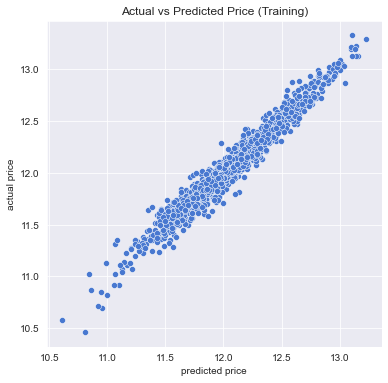

In [63]:
plt.figure(figsize=[6,6])
sns.scatterplot(y=y_train,x=lasso_cv.predict(X_train_lasso));
plt.xlabel('predicted price')
plt.ylabel('actual price')
plt.title('Actual vs Predicted Price (Training)');

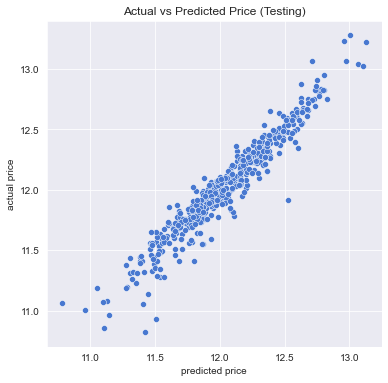

In [64]:
plt.figure(figsize=[6,6])
sns.scatterplot(y=y_test,x=lasso_cv.predict(X_test_lasso));
plt.xlabel('predicted price')
plt.ylabel('actual price')
plt.title('Actual vs Predicted Price (Testing)');

- We see that on training data, the predicted and actual price value lies closely with the 45 degree line.
- We see that on testing data, the predicted and actual price match less closely, but still performing in acceptable ranges.

---- 

### Conclusions and Future Work

As our robust model performance shows, 94.93% of the variation in Sale Price in the training set and 91.13% of the variation in Sale Price in the test set can be explained by the model. This statisfies our defination of a robust model which accounts for over 92% of the target variation. Along with the pred vs actual plot shown above, we can see that this model is fairly good at predictive tasks, with an $R^2$ 0.23 larger than that of our base model, meaning the robust model accounts for 23% more variation in Sale Price than the base model.

As for future work, since we still see slight overfitting in our robust model, the use of clustering to group and lower OHE feature counts may help us reduce model complexity in hope for better bias-variance tradeoff. In addition, more experimentation as to how we perform the train-test-split (i.e. at what ratio) may lead to model performance improvement, as it is a critical 'hyperparametre' which we did not tune using GridSearch. 